# TP subject 1:  Reconstruction of DOSY NMR signals
### Mohamed Amine Hachicha & Khalil Bergaoui

## Part I

##### Read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import exp, log
import scipy.linalg

#x = pd.read_csv(r'C:\Users\hachi\Documents\Centrale 3A\LSD\TP2\x.txt', header=None).values.reshape(1, -1)[0]
x = pd.read_csv(r'x.txt', header=None).values.reshape(1, -1)[0]
#x = np.loadtxt("signal.txt").flatten()

### I.2 Generation of synthetic Data

$\forall \, n \, \in  \, \left \{ 1,..,N \right \}, \:T_{min}.exp(-(n-1)\frac{log(T_{min}/T_{max})}{N-1})$

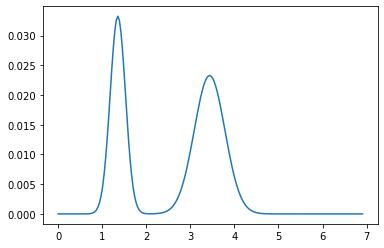

In [2]:
Tmin = 1
Tmax = 1000
N = 200

def calc_Tn(n, Tmin, Tmax, N):
    return Tmin * exp(-(n-1)* log(Tmin/Tmax) / (N-1))

T = []
for i in range(1, N+1):
    T.append(calc_Tn(i, Tmin, Tmax, N))
    
T = np.array(T)


plt.plot(np.log(T), x)
plt.show()

#### Creating t
$\forall \, m \, \in  \, \left \{ 1,..,M \right \}, \: t^{(m)} = t_{min} + \frac{m-1}{M-1}(t_{max}-t_{min})$

In [3]:
def calc_tm(m, tmin, tmax, M):
    return tmin + (m - 1) * (tmax - tmin) / (M - 1)

t = []
M = 50
for i in range(1, M+1):
    t.append(calc_tm(m=i, tmin=0, tmax=1.5, M=M))
    
t = np.array(t)

In [4]:
import random
import sys
seed = random.randrange(sys.maxsize)
rng = random.Random(seed)
print("Seed was:", seed)

Seed was: 4285356327880336688


$(\forall \, m \, \in  \, \left \{ 1,..,M \right \})\, (\forall \, n \, \in  \, \left \{ 1,..,N \right \}),\: \: K^{(m, n)} = exp(-T^{(n)}t^{(m)})$

In [5]:
K = np.zeros((M, N))

for m in range(M):
    for n in range(N):
        K[m, n] = exp(-T[n]*t[m])

##### Simulate the noisy data
$y = K\bar{x} + w$  where $\:  w\sim N(0, \sigma^{2} I_{M})\:, \sigma=0.01$

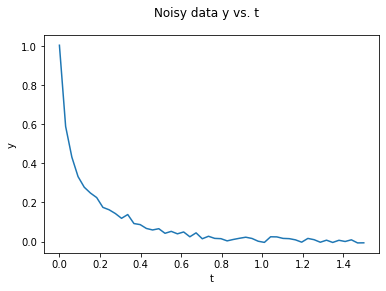

In [6]:
sigma = 0.01 * np.dot(K, x)[0]
random.seed(5959889479172007827) # Fix random seed for reproductible results
y = np.dot(K, x) + np.random.multivariate_normal(mean=np.zeros(M), cov= (sigma ** 2) * np.identity(M))

fig=plt.figure()
plt.suptitle('Noisy data y vs. t')
plt.plot(t, y)
plt.xlabel('t')
plt.ylabel('y')
plt.show()

### I.3.a. Smoothness prior
#### Solving for $g(x) = \frac{1}{2}\left \| Dx \right \|^{2}$
#### I.3.a.1 Existence and unicity of the solution
Let $F(x) = \left \| Kx - y \right \|^2 + \frac{\beta}{2}\left \| Dx \right \|^{2} $
F is twice differentiable and : 
  
$$\nabla F = K^T (Kx-y) + \beta D^T Dx$$ Therefore $ \nabla F(x) = 0 \Leftrightarrow x = (K^TK+\beta D^TD)^{-1} K^T y$
  
In fact, $(K^TK+\beta D^TD)$ is invertible because it is symmetric and :
  
$$v^T (K^TK+\beta D^TD)v=0 \Leftrightarrow v^TK^TKv + \beta v^TD^TDv = 0$$
$$\Leftrightarrow \left \| Kv \right \|^2 + \beta \left \| Dv \right \|^2 = 0$$
$$\Leftrightarrow \left \| Kv \right \|=0 \; and \; \left \| Dv \right \| = 0$$
$$\Leftrightarrow Kv=0 \; and \; Dv=0$$
$$\Leftrightarrow Kv=0 \; and \; v \in Vect((1,...,1))$$
$$\Leftrightarrow v=0$$ because $K.(1,...,1)^T \neq 0$
  
And we have, $\nabla^2F(x) = K^TK+\beta D^TD > 0$ (symmetric definite positive matrix)

Therefore, $\hat{x}=(K^TK+\beta D^TD)^{-1} K^T y$ is a global minimizer of F. It's a unique solution for our problem

#### I.3.a.2 Algorithm
There's not a specific algorithm to solve the problem. We just have to compute $\hat{x}=(K^TK+\beta D^TD)^{-1} K^T y$
  
#### I.3.a.3,4,5 Implementation

The optimal beta value is : 1
The corresponding quadratic error is: 0.5819248120364011


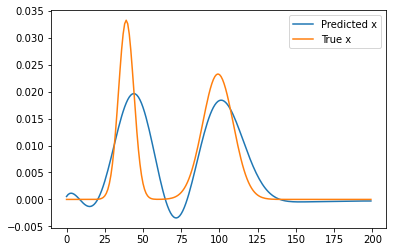

In [9]:
D = np.eye(N) - np.diag(np.ones(N-1), -1)

# tested betas
betas = [2**i for i in range(-6,3)]

x_bars = {}
quad_errors = {}
for beta in betas :
    hessian = (K.T@ K) + beta * D.T @ D
    x_bar = np.linalg.inv(hessian) @ K.T @ y
    x_bars[beta] = x_bar
    quad_errors[beta] = np.linalg.norm(x-x_bar, 1) / np.linalg.norm(x, 1)
    
print('The optimal beta value is : {}'.format(min(quad_errors, key=quad_errors.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors.values())))

fig = plt.figure()
plt.plot(x_bars[min(quad_errors, key=quad_errors.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()

### I.3.b. Smoothness prior with constraints
#### Solving for $g(x) = \frac{1}{2}\left \| Dx \right \|^{2}+ \iota  _{[x_{min}, x_{max}]}(x)$
#### I.3.b.1 Existence and unicity of the solution
We can rewrite our problem as $\hat{x} = \underset{x\in C}{argmin} \; F(x)$, where F is the same function as before, and where $ C = \left \{ x \in \mathbb{R}^N, \; x_{min} \leq x^{(i)} \leq x_{max}, \; 1\leq i \leq N \right \}$
  
C is compact since it is a closed and bounded set in a finite dimension space. By continuity of F, it follows that the set of minimizers is non empty.
  
C is a non empty convex set and since F is strictly convex, our problem has at most one minimizer, which means that we have one unique minimizer for our problem.
  
#### I.3.b.2 Algorithm
F is proper, convex and continuous. F is also $\nu$-Lipschitzian with $\nu$ the largest eigenvalue of $K^TK + \beta D^TD$. This is because:
$$\left \| \nabla F(x)-\nabla F(y) \right \| = \left \| \nabla (K^TK + \beta D^TD)(x-y) \right \| \leq \nu \left \|(x-y) \right \|$$
  
We also have that C is closed and the set of minimizers on C is nonempty.
  
Therefore, we use the projected gradient algorithm. We start with $x_0 \in \mathbb{R}^N$ and then,
$$ \forall k \; \left\{
    \begin{array}{ll}
         y_k = x_k - \gamma (K^TKx_k-K^Ty + \beta D^TDx_k)\\
         x_{k+1} = x_k + \lambda(P_c(y_k)-x_k)\\
    \end{array}
\right.
$$
Where $\gamma \in ]0,2/\nu[$ and $\lambda \in ]0, 2-\nu \gamma /2[$

$$ \forall n \in 1,..,N \; ; (P_C(a))^{(n)} = \; \left\{
    \begin{array}{ll}
         x_{min} & \mbox{if} & a^{(n)}<x_{min} \\
         x_{max} & \mbox{if} & a^{(n)}>x_{max} \\
         a^{(n)} & \mbox{otherwise} & \\
    \end{array}
\right.
$$

#### I.3.b.3,4,5 Implementation

In [10]:
x_max = x.max()
x_min = x.min()
x_0 = np.ones(x.shape) * (x_max + x_min) / 2

def Pc(y, x_min, x_max):
    y_int = y.copy()
    y_int[y_int < x_min] = x_min
    y_int[y_int > x_max] = x_max
    return y_int


# try with tolerance 1e-6
betas = [2**i for i in range(-6,3)]
quad_errors = {}
x_bars = {}

tol = 1e-6
max_iter = 30000

for beta in betas:
    # initialize parameters
    a = K.T @ K + beta * D.T @ D
    v = scipy.linalg.eigh(a)[0].max()
    gamma = 1.999 / v
    lambd = 0.99 * (2 - gamma * v / 2)
    
    x_n = x_0.copy()
    
    for i in range(max_iter):
        x_n_1 = x_n
        y_n = x_n - gamma * (K.T @ K @ x_n - K.T @ y + beta * D.T @ D @ x_n)
        x_n = x_n + lambd * (Pc(y_n, x_min, x_max) - x_n)
        
        if np.linalg.norm(x_n-x_n_1, 1) < tol:
            break
    
    quad_errors[beta] = np.linalg.norm(x-x_n, 1) / np.linalg.norm(x, 1)
    x_bars[beta] = x_n

    
print('The optimal Beta is : {}'.format(min(quad_errors, key=quad_errors.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors.values())))

The optimal Beta is : 0.015625
The corresponding quadratic error is: 0.3989748588709667


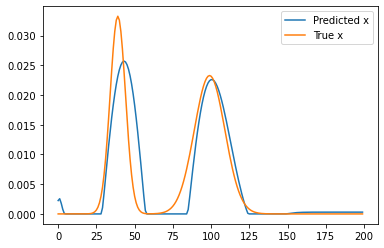

In [11]:
fig = plt.figure()
plt.plot(x_bars[min(quad_errors, key=quad_errors.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()

#### I.3.c Sparsity prior
#### Solving for $g(x)= \left \| x \right \|_{1}$
#### I.3.c.1 Existence and unicity of the solution
Let $H(x) = \left \| Kx-y \right \|^2 + \beta \left \| x \right \|_{1}$
  
We have that $H(x) \geq \beta \left \| x \right \|_{1} \geq \beta C \left \| x \right \|$ where C is the constant from the equivalence of norms in finite dimension.
  
Therefore, H is coercive and then it admits at least one minimizer.
We can't conclude about the uniqueness of the solution.

#### I.3.c.2 Algorithm
$ H = H_1 + H_2$ where $H_1(x) = \left \| Kx-y \right \|^2$ and $H_2(x)=\beta \left \| x \right \|_{1}$
  
$H_1$ and $H_2$ are both proper continuous and convex.
  
$\forall x,y; \; \left \| \nabla H_1(x) - \nabla H_1(y) \right \| = \left \| K^TK(x-y) \right \| \leq v\left \| x-y \right \|$ with ν the largest eigenvalue of $K^TK$. Therefore, $H_1$ is v-Lipschitzian gradient.
  
H has at least one minimizer. Therefore, given all these elements, we can apply the forward backward algorithm.
  
$$ \forall k \; \left\{
    \begin{array}{ll}
         y_k = x_k - \gamma K^T(Kx_k-y)\\
         x_{k+1} = x_k + \lambda(prox_{\gamma \beta \left \| . \right \|_1}(y_k)-x_k)\\
    \end{array}
\right.
$$
Where $\gamma \in ]0,2/\nu[$ and $\lambda \in ]0, 2-\nu \gamma /2[$ and :
$$(prox_{\gamma \beta \left \| . \right \|_1}(z)^{(n)})_{n=1,..,N} = (sign(z^{(n)}).max(\left | z^{(n)} \right |-\gamma \beta, 0))_{n=1,..,N}$$


#### I.3.c.3,4,5 Implementation

The optimal Beta is : 0.03125
The corresponding quadratic error is: 0.37514648037317294


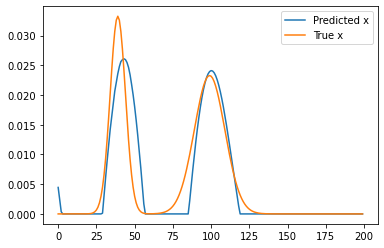

In [12]:
x_max = x.max()
x_min = x.min()
x_0 = np.ones(x.shape) * (x_max + x_min) / 2

# Calculate the proximal operator
def prox(y, gamma, beta):
    y_int = y.copy()
    idx = np.abs(y_int) - gamma * beta > 0
    y_int[idx] = (np.abs(y_int[idx]) - gamma * beta) * np.sign(y_int[idx])
    y_int[~idx] = 0
    return y_int

betas = [2**i for i in range(-6,3)]
quad_errors = {}
x_bars = {}

# try with tolerance 1e-6
max_iter = 30000
tol = 1e-6

for beta in betas:
    # Initialize parameters
    a = K.T @ K + beta * D.T @ D
    v = scipy.linalg.eigh(a)[0].max()
    gamma = 1.999 / v
    lambd = 0.99 * (2 - gamma * v / 2)
    
    x_n = x_0.copy()
    
    for i in range(max_iter):
        x_n_1 = x_n
        y_n = x_n - gamma * K.T @ (K @ x_n - y)
        x_n = x_n + lambd * (prox(y_n, gamma, beta) - x_n)
        if np.linalg.norm(x_n - x_n_1, 1) < tol:
            break
    quad_errors[beta] = np.linalg.norm(x-x_n, 1) / np.linalg.norm(x, 1)
    x_bars[beta] = x_n

print('The optimal Beta is : {}'.format(min(quad_errors, key=quad_errors.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors.values())))

fig = plt.figure()
plt.plot(x_bars[min(quad_errors, key=quad_errors.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()

## Part II : Maximum entropy regularization

#### Solving for $g(x)=ent(x)$ where ent is the entrpy regularization function

$\forall x = (x_i)_{1\leq i\leq n} \in \mathbb{R^n} ent(x) = \sum \varphi(x_i)$ ; where

$$ \forall u \in \mathbb{R} \
\varphi(u) = \left\{
    \begin{array}{ll}
         ulogu  & \mbox{if} & u > 0 \\
         0 & \mbox{if} & u = 0\\
        +\infty & \mbox{else}
    \end{array}
\right.
$$

1.1 $\varphi$ is proper lower, semi continuous function. In fact $\varphi$ is continuous at $0^+$: $\lim_{u\to0+} ulogu = 0 = \varphi(0)$ and has a closed epigraph.

1.2 $\varphi$ is infinitely smooth over ]$0,+\infty$\[ and $\varphi''(u) = \frac{1}{u} > 0$ So $\varphi$ is strictly convex.

1.3 Differentiability: $\varphi$ is differentiable over ]$0,+\infty$\[ but is not differentiable in 0: 
$$\lim_{u\to0^+} \frac{\varphi(u) - \varphi(0)}{u} =  \lim_{u\to0^+} log(u) = -\infty$$

2. From question 1, we deduce that $ent(x)$ is proper, l.s.c and strictly convex. The quadratic term is convex and is strictly convex if and only if its hessian matrix $K^TK$ is definite positive.  The optimization function $m(x) = \frac{1}{2}{\lVert Kx - y \rVert}^2 + \beta ent(x)$ is strictly convex , proper and l.s.c. 

Therefore the optimization problem has a unique solution.

3. Using Lambert-W function $W$ we can write $\forall x \in \mathbb{R^n}$ :
$$
prox_{\gamma\beta ent}(x) = (prox_{\gamma\beta \varphi}(x_i))_{1\leq i\leq n} \ where \\
prox_{\gamma\beta \varphi}(x_i) = \gamma\beta W( \exp( \frac{x_i}{\gamma\beta}-1-ln(\gamma\beta) ))
$$

4. To solve the optimization problem, we will first implement the Forward Backward algorithm and then Douglas Rachford algorithm, given by the below equations :

#### Notations

$ g = \frac{1}{2}{\lVert K. - y \rVert}^2  \in \Gamma_0(\mathbb{R^n}) \text{ and differentiable over }\mathbb{R^n} : \nabla g(x) = K^T(Kx-y)\ \text{ with Lipschitz constant of the gradient  }\nu = Sup(\frac{{\lVert \nabla^2 g(x)\rVert}}{{\lVert x\rVert}}) $

$ f =\beta ent(.) \in \Gamma_0(\mathbb{R^n}) \text{ not differentiable over }\mathbb{R^n} $ 



$\gamma_{1} = 0.99*\frac{2}{\nu}$

$\lambda_{1} = 0.99*(2-\gamma\frac{\nu}{2}) $

#### Forward Backward:

$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
          x_0 \in\mathbb{R^n} \text{ Given initial point}\\
         y_n =  x_n - \gamma_{1}\nabla g(x_n)  \\
         x_{n+1} = x_n + \lambda_{1}(prox_{\gamma_{1} f}(y_n) - x_n)
    \end{array}
\right.
$$

#### Douglas Rachford:

We fix constants  $\gamma_{2}>0$ and $0<\lambda_{2}<2$ 
$$  \forall n \in \mathbb{N} \
\left\{
    \begin{array}{ll}
         x_0 \in\mathbb{R^n} \text{ Given initial point}\\
         y_n =  prox_{\gamma_{2} g}(x_n) \\
         z_n =  prox_{\gamma_{2} f}(2y_n - x_n)\\
         x_{n+1} = x_n + \lambda_{2}(z_n - y_n)
    \end{array}
\right.
$$


5. We implement both algorithms and test them for a value of $\beta = 0.01$. In our tests, we estimate that the algoithm converges if $|x_{n+1} - x_n| < tol = 10^{-6} $. In this configuration, the two algorithms converge to the same final state and perform poorly : We obtain the same reconstruction error $E(x_{predicted},x) = 1.148 >> 0$.

Therefor we need to finetune the hyperparameter $\beta$ and choose the optimal one in terms of reconstruction error.

### Forward Backward Algorithm

The optimal Beta is : 0.0078125
The corresponding quadratic error is: 1.0929922408817598


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


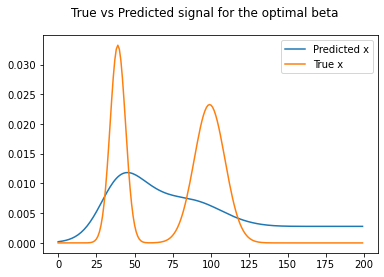

In [13]:
from scipy.special import lambertw

x_max = x.max()
x_min = x.min()
x_0 = np.ones(x.shape) * (x_max + x_min) / 2

# Calculate the entropy function proximal operator
def prox_entropy(y, gamma, beta):
    return gamma * beta * lambertw(np.exp(y/(gamma*beta)-1-log(gamma*beta)))

betas = [2**i for i in range(-7,3)] + [1e-2]

quad_errors_fwbw = {}
x_bars_fwbw = {}

#a = (np.dot(np.transpose(K), K) + beta * np.dot(np.transpose(D), D))
a = K.T @ K
v = scipy.linalg.eigh(a)[0].max()
gamma = 1.999 / v
lambd = 0.99 * (2 - gamma * v / 2)
# try with tolerance 1e-6
max_iter = 10000
tol = 1e-6

for beta in betas:
    # Initialize parameters
    x_n = x_0.copy()
    
    for i in range(max_iter):
        x_n_1 = x_n
        y_n = x_n - gamma * K.T @ (K @ x_n - y)
        x_n = x_n + lambd * (prox_entropy(y_n, gamma, beta) - x_n)
        if np.linalg.norm(x_n - x_n_1, 1) < tol:
            break
    quad_errors_fwbw[beta] = np.linalg.norm(x-x_n, 1) / np.linalg.norm(x, 1)
    x_bars_fwbw[beta] = x_n

print('The optimal Beta is : {}'.format(min(quad_errors_fwbw, key=quad_errors_fwbw.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors_fwbw.values())))

fig = plt.figure()
plt.suptitle('True vs Predicted signal for the optimal beta')
plt.plot(x_bars_fwbw[min(quad_errors_fwbw, key=quad_errors_fwbw.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()

### Douglas-Rashford algorithm

The optimal Beta is : 0.0001220703125
The corresponding quadratic error is: 0.4042596811744323


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


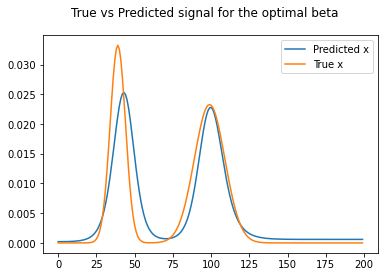

In [14]:
from scipy.special import lambertw
def prox_entropy(y, gamma, beta):
    return gamma * beta * lambertw(np.exp(y/(gamma*beta)-1-log(gamma*beta)))

x_max = x.max()
x_min = x.min()
x_0 = np.ones(x.shape) * (x_max + x_min) / 2


def prox_util(v, K, y, gamma):
    # This function calculates the proximal of f(x) = 0.5*gamma*||K.x-y||²
    term1 = gamma * K.T @ K + np.eye(K.shape[1])
    term2 = gamma * K.T @ y + v
    return np.dot(np.linalg.inv(term1), term2)

betas = [2**i for i in range(-14,0)] + [1e-2]

quad_errors_doug = {}
x_bars_doug = {}

gamma = 1
lambd = 1

# try with tolerance 1e-6
max_iter = 30000
tol = 1e-6

for beta in betas:
    # Initialize parameters
    x_n = x_0.copy()
    
    for i in range(max_iter):
        x_n_1 = x_n
        y_n = prox_entropy(x_n_1, gamma, beta)
        z_n = prox_util(v=2*y_n-x_n_1, K=K, y=y, gamma=gamma)
        x_n = x_n_1 + lambd * (z_n - y_n)
        if np.linalg.norm(x_n - x_n_1, 1) < tol:
            #print('breaking after {}/{} iterations'.format(i+1,max_iter))
            break
    quad_errors_doug[beta] = np.linalg.norm(x-z_n, 1) / np.linalg.norm(x, 1)
    x_bars_doug[beta] = z_n

print('The optimal Beta is : {}'.format(min(quad_errors_doug, key=quad_errors_doug.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors_doug.values())))

fig = plt.figure()
plt.suptitle('True vs Predicted signal for the optimal beta')
plt.plot(x_bars_doug[min(quad_errors_doug, key=quad_errors_doug.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()

6. We test the Douglas-Rashford algorithm, after fixing $\gamma=1=\lambda$,  for a range of values $\beta = 2^i \text{ i such that } -14\leq i \leq -1$

The optimal reconstruction error is eqal to 0.79 , obtained with $\beta = 2^{-13} = 1.2 *10^{-4}$ . 

<u>**Remark :**</u> 

The value of $\beta$ giving best reconstruction error, 0.0001 is close to zero. This explains why for such range of small values, the forward backward algorithm is not a good choice. In fact if we look at the proximity operator of the entropy prior:  
$$prox_{\gamma\beta \varphi}(x_i) = \gamma\beta W( \exp( \frac{x_i}{\gamma\beta}-1-ln(\gamma\beta) ))$$

We observe that, for a fixed constant $\gamma$ we have $\lim_{\beta\to0^+} \exp( \frac{1}{\gamma\beta}-1-ln(\gamma\beta) ) = +\infty$

Therefore, knowing optimal $\beta$ values will be small, it is necessary to use higher values of $\gamma$ to allow for numerical computations. This is exactly limited when using the **Forward Backward algorithm, because it imposes, for convergence purposes, an upper bodary for $\gamma < \frac{2}{\nu} \approx 0.004 $  in our case, hence the limitation !**

**So, since the Douglas Rachford algorithm only requires $\gamma > 0$ , it is most suitable when using the entropy prior.**

7. In terms of the reconstruction error, the smoothness prior with constraints as well as the sparsity prior perform better than the entropy regularization. However, in terms of reconstruction quality, the entropy reglarization gives a smoother predicted signal. This can be observed when the signal x has rapid variations, for instance at $t=25$ and $t=125$. The priors used in Part 1 do not predict a smooth signal around these rapid-variation instants.

Remark : For comparison, we fix the same convergence criteria : the algorithm is considered to converge as soon as the difference between successive iterations is lower than $10^{-6}$


8. We will use the **PPXA+ algorithm.**

By noting C the ball of center $y$ and radius $R$ such that $R^2 = \eta M\sigma^2$ for a given $\eta>0\;$ , we can reformulate the minimization problem as follows:
Find $\hat{x} = \underset{x\in \mathbb{R^n}}{argmin} \; ent(x) + i_C(Kx) \; = g_1\circ L_1(x) + g_2\circ L_2(x) \;$ where:

$L_1(x) = x \\ L_2(x) = K^Tx \\ g_1 = ent \\g_2 = i_C$

Thus we can write the proximal operators for the entropy $g_1$ :

$$
prox_{\gamma g_1}(x) = prox_{\gamma ent}(x) = (prox_{\gamma \varphi}(x_i))_{1\leq i\leq n} \ where \\
prox_{\gamma \varphi}(x_i) = \gamma W( \exp( \frac{x_i}{\gamma}-1-ln(\gamma) ))
$$

For $g_2 = i_C $ the proximal operator is the orthogonal projection over C:

$$  prox_{\gamma g_2}(x) =  \
\left\{
    \begin{array}{ll}
          x & \mbox{if} & \lVert x-y\rVert \leq R\\
         y + \frac{x-y}{\lVert x-y\rVert}*R & \mbox{if} & \lVert x-y\rVert > R \\
    \end{array}
\right.
$$



##### Initialization:
Given  $x_0^1 \; ,x_0^2 \; : v_0 = (I_N + K^T.K)^{-1}). (x_0^1 +K^Tx_0^2 )$

For fixed $\gamma>0$ and $0<\lambda<2$ 
$$  \forall n \in \mathbb{N} ,i \in\{1,2\}\
\left\{
    \begin{array}{ll}
         v_0 = (I_N + K^T.K)^{-1}). (x_0^1 +K^Tx_0^2 )\\
         y_n^i =  prox_{\gamma_{g_i}}(x_n^i) \\
         c_n =  (I_N + K^T.K)^{-1}.(y_n^1 +K^Ty_n^2 )\\
         x_{n+1}^i = x_n^i + \lambda*(L_i(c_n - v_n)-y_n^i)\\
         v_{n+1} = v_n + \lambda*(c_n - v_n)\\
    \end{array}
\right.
$$

Below is the corresponding implementation:




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

------- Training for different values of eta in progress -------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:02<00:00, 18.20s/it]

###############
The optimal Eta is : 0.05
The corresponding quadratic error is: 0.3857741753930182


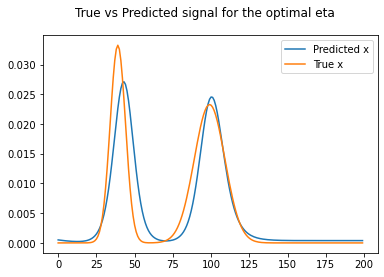

In [16]:
from scipy.special import lambertw
from tqdm import tqdm

def prox_entropy(y, gamma):
    return gamma * lambertw(np.exp(y/(gamma)-1-log(gamma)))
x_max = x.max()
x_min = x.min()

def proj_C(v, C, R):
    if np.linalg.norm(v-C, 2) < R:
        return v
    else:
        return C + (v - C) * R / np.linalg.norm(v-C, 2)

eta_s = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
quad_errors_ppxa = {}
x_bars_ppxa = {}


x_1_0 = np.ones(x.shape) * (x_max + x_min) / 2
x_2_0 = 0.1 * np.ones(M)
v_0 = np.linalg.inv(np.eye(N) + K.T @ K) @ (x_1_0 + K.T @ x_2_0)


max_iter = 20000
tol = 1e-6


lambd = 0.5
gamma = 1

print('------- Training for different values of eta in progress -------')
for eta in tqdm(eta_s):
    x_1_n = x_1_0.copy()
    x_2_n = x_2_0.copy()
    v_n = v_0.copy()
    for i in range(max_iter):
        v_n_1 = v_n.copy()
        y_1_n = np.real(prox_entropy(x_1_n, gamma=gamma))
        y_2_n = proj_C(x_2_n, C=y, R=np.sqrt(M*eta)*sigma)
        c_n = np.linalg.inv(np.eye(N) + K.T @ K) @ (y_1_n + K.T @ y_2_n)
        x_1_n += lambd * (2 * c_n - v_n - y_1_n)
        x_2_n += lambd * (K @ (2 * c_n - v_n) - y_2_n)
        v_n += lambd * (c_n - v_n)
        if np.linalg.norm(v_n - v_n_1) < tol:
            break
    quad_errors_ppxa[eta] = np.linalg.norm(x-v_n, 1) / np.linalg.norm(x, 1)
    x_bars_ppxa[eta] = v_n

print('###############')
print('The optimal Eta is : {}'.format(min(quad_errors_ppxa, key=quad_errors_ppxa.get)))
print('The corresponding quadratic error is: {}'.format(min(quad_errors_ppxa.values())))

fig = plt.figure()
plt.suptitle('True vs Predicted signal for the optimal eta')
plt.plot(x_bars_ppxa[min(quad_errors_ppxa, key=quad_errors_ppxa.get)], label='Predicted x')
plt.plot(x, label='True x')
plt.legend()
plt.show()